# Toy Dynamics

We consider the following planar system for $\varepsilon > 0$:
$$
\begin{align*}
 \dot{x_1} &= - x_1 + (x_1^2 + \varepsilon) u_1 \:, \\
 \dot{x_2} &= - x_2 + (x_2^2 + \varepsilon) u_2 \:.
\end{align*}
$$
Our desired safe set is $\mathcal{S} := \{ x : x_1 \leq 1, x_2 \leq 1 \}$.
It is not hard to see that $h(x) := \min\{ 1 - x_1, 1 - x_2 \}$ is a CBF with $\alpha(x) = x$
(this is Ex. 1 in https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8405547).

Given an $r > 0$, we start the system at $x(0) = (-r, 0)$ and follow the trajectory $x_d(t) = \begin{bmatrix} - r \cos(t) \\ r \sin(t) \end{bmatrix}$ from $t=0$ to $t=2\pi$. Notice that $x(0) \in \mathcal{S}$ by construction. When $r > 1$, following the trajectory $x_d$ exactly will cause the system to leave the safe set $\mathcal{S}$, so we will use the CBF to keep the system safe. 

In order to build the controller, we will feedback linearize the system. Define $e = x - x_d$, observe that the input:
$$
u = g(x)^{-1}( \dot{x_d} + x - k e )
$$
results in the closed loop dynamics $\dot{e} = - ke$ ($g(x)$ is invertible as long as $x_1 \neq 0$ and $x_2 \neq 0$).

In [42]:
import jax.numpy as np
import jax
import numpy as onp
import matplotlib.pylab as plt
import scipy
import cvxpy as cp
#import mosek

from jax import random, vmap, jit, grad, ops, lax, tree_util, device_put, device_get, jacobian, jacfwd, jacrev, jvp
from jax.flatten_util import ravel_pytree
from jax.experimental import optimizers

from functools import partial
import time

In [43]:
eps = 1.0
def dynamics(x, u):
    return -x + ((x**2 + eps) * u)

def dynamics_f(x):
    return -x

def dynamics_g(x):
    return np.diag(x**2 + eps)

def h(x):
    return np.min(1 - x)

def make_xdes_circle(r):
    assert r > 0
    def xd(t):
        return np.array([-r*np.cos(t), r*np.sin(t)])
    return xd

def make_xdes_direction(direction, t0):
    """Make the follow desired trajectory:
    
    x_d(t) = direction * (t - t0)
    
    """
    return lambda t: direction * (t - t0)

def make_feedback_linearizing_controller(xd, k):
    assert k > 0
    xddot = jax.jacobian(xd)
    
    def controller(x, t):
        return (1/(x**2 + eps)) * (xddot(t) + x - k * (x - xd(t)))
    
    return controller

def h_constraint(x, u):
    gradh = jax.grad(h)
    dh = gradh(x)
    return np.dot(dh, dynamics(x, u)) + h(x)

def is_in_safe_set(x):
    return (x <= 1).all()

In [44]:
t_end = 2 * np.pi
t_eval = np.linspace(0, t_end, num=100)
r = 1.5
controller = make_feedback_linearizing_controller(make_xdes_circle(r), 1.0)
x_start = np.array([-r, 0])
closed_loop = jax.jit(lambda t, y: dynamics(y, controller(y, t)))
res = scipy.integrate.solve_ivp(closed_loop, (0, t_end), x_start, t_eval=t_eval)
traj = res.y.T

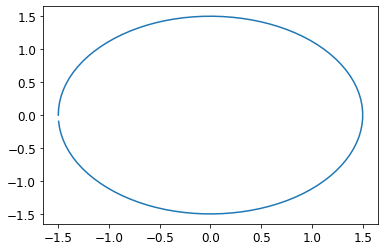

In [45]:
plt.plot(traj[:, 0], traj[:, 1])
#plt.plot(t_eval[:-1], jax.vmap(controller, in_axes=(0, 0))(traj, t_eval[:-1]))

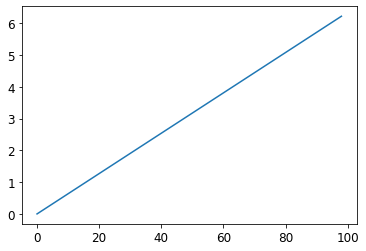

In [46]:
direction = np.array([1, 1])
xdes = make_xdes_direction(direction, 0.0)
controller = make_feedback_linearizing_controller(xdes, 1.0)
x_start = np.array([0.0, 0.0])
closed_loop = jax.jit(lambda t, y: dynamics(y, controller(y, t)))
res = scipy.integrate.solve_ivp(closed_loop, (0, t_end), x_start, t_eval=t_eval)
traj = res.y.T
plt.plot(traj[:, 1])

In [47]:
def make_safe_controller(r, k, h, h_args):
    
    opt_controller = jax.jit(make_feedback_linearizing_controller(make_xdes_circle(r), k))
    gradh = jax.jit(jax.grad(h, argnums=0))
    
    def safe_controller(x, t):
        #print("x", x)
        #print("t", t)
        u_opt = jax.device_get(opt_controller(x, t))
        f = jax.device_get(dynamics_f(x))
        g = jax.device_get(dynamics_g(x))
        hx = jax.device_get(h(x, *h_args))
        dh = jax.device_get(gradh(x, *h_args))
        x = jax.device_get(x)
        
        # solve QP for u_mod
        u_mod = cp.Variable(len(x))
        obj = cp.Minimize(cp.sum_squares(u_mod - u_opt))
        constraints = [onp.dot(dh, f) + u_mod.T @ onp.dot(g.T, dh) + hx >= 0]
        prob = cp.Problem(obj, constraints)
        result = prob.solve(solver=cp.SCS, verbose=False)
        if prob.status != cp.OPTIMAL:
            print("WARNING: problem status " + str(prob.status))
        #print("u_opt", u_opt)
        #print("u_mod", u_mod.value)
        return u_mod.value
    
    return safe_controller

In [48]:
def generate_training_data(r, num_points):
    safe_controller = make_safe_controller(r, 1, h, ())
    safe_closed_loop = lambda t, y: dynamics(y, safe_controller(y, t))
    x_start = np.array([-r, 0])
    t_end = 2 * np.pi
    t_eval = np.linspace(0, t_end, num=num_points)
    assert t_eval[-1] <= t_end
    res = scipy.integrate.solve_ivp(safe_closed_loop, (0, t_end), x_start, t_eval=t_eval)
    X_train = res.y.T
    U_train = np.array([safe_controller(x, t) for x, t in zip(X_train, t_eval)])
    return X_train, U_train

In [49]:
class PRNG(object):
    def __init__(self, seed):
        self.key = random.PRNGKey(seed)
    def next(self):
        k1, k2 = random.split(self.key)
        self.key = k1
        return k2
rng = PRNG(549394)

In [50]:
N = 80

# safe data
data = [
    #generate_training_data(r=1.75, num_points=100),
    generate_training_data(r=.3333, num_points=N),
    generate_training_data(r=.3, num_points=N),
    generate_training_data(r=.2666, num_points=N),
    #generate_training_data(r=.1, num_points=100)
]

x_constraint = np.vstack([X for X, _ in data])
u_constraint = np.vstack([U for _, U in data])

In [51]:
# safe samples -- should be set to 0 to replicate example in the paper; set to nonzero will result in a control barrier filter;
n_safe_samples = 0
if n_safe_samples:
    safe_points = np.vstack((random.uniform(rng.next(), shape=(n_safe_samples,), minval=-.1, maxval=.1),
                             random.uniform(rng.next(), shape=(n_safe_samples,), minval=-.1, maxval=.1))).T

    # also add all x_constraint to safe samples
    safe_points = np.vstack((safe_points))

    assert vmap(is_in_safe_set)(safe_points).all()

In [52]:
# unsafe samples -- these need to tightly envelope expert trajectories

# boundary data
unsafe_data = [ generate_training_data(r=.1, num_points=int(N/2)),
                generate_training_data(r=.5, num_points=N)]
unsafe_points = np.vstack([X for X, _ in unsafe_data])
unsafe_inputs = np.vstack([U for _, U in unsafe_data])

In [53]:
def modify_orthogonal_input(dataset, inwards):
    # modify the u to point the vector field either inwards or outwards
    x_train, u_train = dataset
    def modify(x, u):
        direction = -x if inwards else x
        return (1/(x**2 + eps)) * (direction + x)
    return x_train, vmap(modify)(x_train, u_train)

In [54]:
# filler trajectories to enforce derivative constraints, but not h(x)>=0 between expert traj and unsafe data-points
filler_data = [    
            modify_orthogonal_input(generate_training_data(r=.1333, num_points=int(N/2)), inwards=False), 
            modify_orthogonal_input(generate_training_data(r=.1666, num_points=int(N/2)), inwards=False),
            modify_orthogonal_input(generate_training_data(r=.2, num_points=int(N/2)), inwards=False),
            modify_orthogonal_input(generate_training_data(r=.2333, num_points=int(N/2)), inwards=False),
    
            modify_orthogonal_input(generate_training_data(r=.3666, num_points=N), inwards=True),
            modify_orthogonal_input(generate_training_data(r=.4, num_points=N), inwards=True),
            modify_orthogonal_input(generate_training_data(r=.4333, num_points=N), inwards=True),
            modify_orthogonal_input(generate_training_data(r=.4666, num_points=N), inwards=True)
]
x_filler = np.vstack([X for X, _ in filler_data])
u_filler = np.vstack([U for _, U in filler_data])

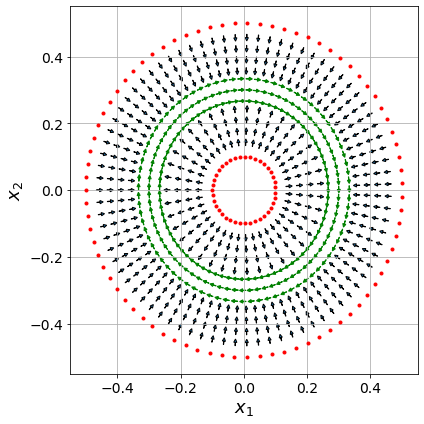

In [55]:
# visualize the collected training data

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

plt.figure(figsize=(6, 6))

plt.plot(unsafe_points[:, 0], unsafe_points[:, 1], 'r.')
if n_safe_samples:
    plt.plot(safe_points[:, 0], safe_points[:, 1], 'b.')
#plt.plot(x_constraint[:, 0], x_constraint[:, 1], 'g.')
#plt.plot(x_filler[:, 0], x_filler[:, 1], 'k.')

for xpt, upt in zip(x_constraint, u_constraint):
    fxu = dynamics(xpt, upt)
    d = 0.01 * (fxu / np.linalg.norm(fxu))
    plt.arrow(xpt[0], xpt[1], d[0], d[1], edgecolor='green', facecolor='green', head_width=0.01, head_length=0.01)

# plot arrows inwards and outwards 
for pt in x_filler:
    # hack
    if np.linalg.norm(pt) >= 0.3:
        # point inwards
        d = - 0.01 * (pt / np.linalg.norm(pt))
        plt.arrow(pt[0], pt[1], d[0], d[1], head_width=0.01, head_length=0.01)
    else:
        # point outwards
        d = 0.01 * (pt / np.linalg.norm(pt))
        plt.arrow(pt[0], pt[1], d[0], d[1], head_width=0.01, head_length=0.01)


plt.grid()

plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)

#plt.legend(['Unsafe points', 'Safe points', 'Dynamic points'], fontsize=18)
plt.tight_layout()
plt.savefig('toy_2d_sampling_points.pdf', bbox_inches='tight')

## Quick comments
In the plot above, expert trajectories that are enforced to be safe (i.e., are in $\bar{X}_{\mathrm{safe}}$)) are in green, and the "filler" expert trajectories are in black.  The direction of the arrows show the vector field $f(x,u)$ at that point. Although, for convenience, we used trajectories to generate the unsafe samples, we only collect the $x$ data (not the control inputs), which are denoted by the red points.

In [56]:
@jit
def lipschitz_h(x, params, bias_param, rf_weights):
    dh = grad(h_model, argnums=0)(x, params, bias_param, rf_weights)
    return np.linalg.norm(dh)

@jit
def lipschitz_grad_h(x, params, bias_param, rf_weights):
    # http://www.bnikolic.co.uk/blog/python/2020/01/28/jax-hessian.html
    return np.linalg.norm(
        jacfwd(jacrev(h_model, argnums=0), argnums=0)(x, params, bias_param, rf_weights),
        ord=2)

@jit
def lipschitz_constraint_q(x, u, params, bias_param, rf_weights):
    # define q(x, u) := < grad h, dynamics(x, u) > + alpha(h(x))
    # computes lipschitz constant of q w.r.t. x at (x, u)
    
    def q(x, u):
        dh = grad(h_model, argnums=0)(x, params, bias_param, rf_weights)
        return np.dot(dh, dynamics(x, u)) + alpha(h_model(x, params, bias_param, rf_weights))
    
    dq = grad(q, argnums=0)(x, u)
    return np.linalg.norm(dq)

@jit
def derivative_constraint_slack(x, u, params, bias_param, rf_weights,eps):
    # returns hdot(x,u) - alpha(h(x)) - eps L_q(x) (we want this to be positive)
    Lx = lipschitz_constraint_q(x, u, params, bias_param, rf_weights)
    constraint_val = r_with_input(x, u, params, bias_param)
    
    return constraint_val - eps*Lx

@jit
def unsafe_constraint_slack(x, params, bias_param, rf_weights, eps):
    # returns h(x) + \bar{eps} L_h(x) (we want this to be negative)
    Lx = lipschitz_h(x, params, bias_param, rf_weights)
    constraint_val = h_model(x, params, bias_param, rf_weights)
    
    return constraint_val + eps*Lx

@jit
def safe_constraint_slack(x, params, bias_param, rf_weights, eps):
    # returns h(x) + \bar{eps} L_h(x) (we want this to be negative)
    Lx = lipschitz_h(x, params, bias_param, rf_weights)
    constraint_val = h_model(x, params, bias_param, rf_weights)
    
    return constraint_val - eps*Lx

# RF Training

In [57]:
# make the random features map
n_random_features = 200
x_dim = 2
u_dim = 2
sigma = 1.2 # bandwidth of gaussian kernel
psi = 1.0

def alpha(x):
    return psi * x

rf_weights = (random.normal(rng.next(), shape=(x_dim, n_random_features))*sigma, 
              random.uniform(rng.next(), minval=0, maxval=2*np.pi, shape=(n_random_features,)))

def phi(X, rf_weights):
    W, b = rf_weights
    n_rf = len(b)
    return np.sqrt(2.0 / n_rf) * np.cos(X.dot(W) + b)

def h_model(x, theta, bias, rf_weights):
    return phi(x, rf_weights).dot(theta) + bias

In [58]:
def solve_model(gamma_xu_constraints, gamma_xu_fillers, safe_values, unsafe_values, verbose):
    assert len(gamma_xu_constraints) == x_constraint.shape[0]
    assert (gamma_xu_constraints >= 0).all()
    assert len(gamma_xu_fillers) == x_filler.shape[0]
    assert (gamma_xu_fillers >= 0).all()
    assert len(safe_values) == x_constraint.shape[0]
    assert (safe_values >= 0).all()
    assert len(unsafe_values) == unsafe_points.shape[0]
    assert (unsafe_values <= 0).all()
    
    assert not n_safe_samples # no CBF filters for now
    
    theta = cp.Variable(n_random_features)
    bias = cp.Variable()
    param_cost = cp.sum_squares(theta) + bias ** 2 #cp.Minimize(cp.sum_squares(theta))
    lam_safe = 1
    
    use_bias = True
    
    constraints = []

    if not use_bias:
        constraints.append(bias == 0)

    # hdot + alpha(h) >= gamma constraints
    # for expert safe trajectories
    phis = device_get(phi(x_constraint, rf_weights))
    Dphixdots = device_get(
        vmap(lambda x, u: np.dot(jacobian(phi, argnums=0)(x, rf_weights), dynamics(x, u)), 
             in_axes=(0, 0))(x_constraint, u_constraint))

    for this_phi, this_Dphixdot, this_gamma in zip(phis, Dphixdots, gamma_xu_constraints):
        constraints.append((theta.T * (this_Dphixdot + psi * this_phi) + psi * bias) >= this_gamma)
        
#     # for expert unsafe trajectories
#     phis = device_get(phi(unsafe_points, rf_weights))
#     Dphixdots = device_get(
#         vmap(lambda x, u: np.dot(jacobian(phi, argnums=0)(x, rf_weights), dynamics(x, u)), 
#              in_axes=(0, 0))(unsafe_points, unsafe_inputs))
#     for this_phi, this_Dphixdot, this_gamma in zip(phis, Dphixdots, gamma_xu_constraints):
#         constraints.append((theta.T * (this_Dphixdot + psi * this_phi) + psi * bias) >= this_gamma)

    # for expert filler trajectories
    phis = device_get(phi(x_filler, rf_weights))
    Dphixdots = device_get(
        vmap(lambda x, u: np.dot(jacobian(phi, argnums=0)(x, rf_weights), dynamics(x, u)), 
             in_axes=(0, 0))(x_filler, u_filler))

    for this_phi, this_Dphixdot, this_gamma in zip(phis, Dphixdots, gamma_xu_fillers):
        constraints.append((theta.T * (this_Dphixdot + psi * this_phi) + psi * bias) >= this_gamma)

    # safe constraints
    safe_cost = 0
    phis = device_get(phi(x_constraint, rf_weights))
    for this_phi, this_safe_value in zip(phis, safe_values):
        constraints.append((theta.T * this_phi + bias) >= this_safe_value)
        safe_cost += (theta.T * this_phi + bias - lam_safe) ** 2

    # if we're implementing CBF filters
    if n_safe_samples:
        phis = device_get(phi(safe_points, rf_weights))
        for this_phi in phis:
            constraints.append((theta.T * this_phi + bias) >= safe_value)
            safe_cost += (theta.T * this_phi + bias - lam_safe) ** 2

    # unsafe constraints
    unsafe_cost = 0
    phis = device_get(phi(unsafe_points, rf_weights))
    for this_phi, this_unsafe_value in zip(phis, unsafe_values):
        constraints.append((theta.T * this_phi + bias) <= this_unsafe_value)
        unsafe_cost += (theta.T * this_phi + bias + lam_safe) ** 2

    #  Penalize norm of jacobian
    x_all = np.vstack((x_constraint,unsafe_points))
    phis = device_get(phi(x_all, rf_weights))
    Dphis = device_get(
        vmap(lambda x: jacobian(phi, argnums=0)(x, rf_weights), in_axes=(0))(x_all))

    dh_cost = 0
    for this_Dphi in Dphis:
        dh_cost += cp.sum_squares(theta.T @ this_Dphi)

    #try to pull safe values up
    obj = cp.Minimize(param_cost+0*safe_cost+0*unsafe_cost+dh_cost)

    params = None
    bias_param = None
    prob = cp.Problem(obj, constraints)
    solver = cp.MOSEK
    if solver == cp.MOSEK:
        import mosek
        mosek.dparam.basis_rel_tol_s=1e-2
        mosek.dparam.basis_tol_s=1e4
        mosek.dparam.basis_rel_tol_x=1e-2
        mosek.dparam.basis_tol_x=1e4
        
    result = prob.solve(solver=solver, verbose=verbose)
    assert prob.status in (cp.OPTIMAL, cp.OPTIMAL_INACCURATE)
    params = device_put(theta.value)
    bias_param = device_put(bias.value)
    return params, bias_param

In [59]:
# initial
safe_value = 0.1
unsafe_value = -.3
#boundary_delta = 0.05
gamma = 0.01

params, bias_param = solve_model(
    gamma_xu_constraints=gamma*np.ones((x_constraint.shape[0],)),
    gamma_xu_fillers=gamma*np.ones((x_filler.shape[0],)),
    safe_values=safe_value*np.ones((x_constraint.shape[0],)),
    unsafe_values=unsafe_value*np.ones((unsafe_points.shape[0],)),
    verbose=True)



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3754            
  Cones                  : 712             
  Scalar variables       : 3603            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3754            
  Cones                  : 712             
  Scalar variables       : 3603            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 16              
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 2841
Optimizer  - Cones                  : 712
Optimizer  - Scalar variab

# Evaluation

In [60]:
print("bias value", bias_param)

bias value -92.31253


In [61]:
if n_safe_samples:
    plt.plot(vmap(h_model, in_axes=(0, None, None, None))(safe_points, params, bias_param, rf_weights), '.')
    plt.plot(np.arange(len(safe_points)), safe_value*np.ones((len(safe_points),)), '--')

In [62]:
def r_with_input(x, u, params, bias_param):
    dh = grad(h_model, argnums=0)(x, params, bias_param, rf_weights)
    return np.dot(dynamics_f(x), dh) + np.dot(dynamics_g(x).T.dot(dh), u) + alpha(h_model(x, params, bias_param, rf_weights))

In [63]:
# grid to see what the superlevel set h(x) is
x1 = np.linspace(-2, 2, num=50)
x2 = np.linspace(-2, 2, num=50)

#params = init_params
hvals = vmap(lambda s1: vmap(lambda s2: h_model(np.array([s1, s2]), params, bias_param, rf_weights))(x2))(x1)

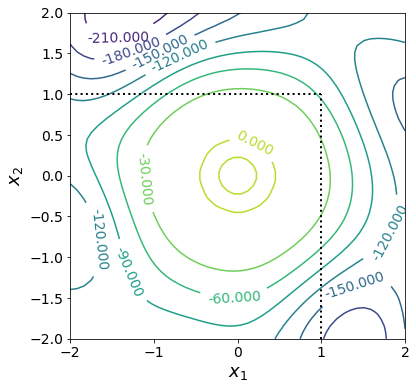

In [64]:
#visualize level sets at h(x) = -100, 0, 100

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

plt.figure(figsize=(6, 6))
cntr_plt = plt.contour(np.linspace(-2, 2, num=50),np.linspace(-2, 2, num=50),hvals.T)
plt.clabel(cntr_plt, inline=1, fontsize=14)
plt.plot(np.linspace(-2, 1, num=20), np.ones((20,)), 'k:', linewidth=2)
plt.plot(np.array([1, 1]), np.array([-2, 1]), 'k:', linewidth=2)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
plt.savefig('toy_2d_level_set.pdf', bbox_inches='tight')

Notice that the zero level sets, in lime green, are well within the safe set, demarcated by the dotted black line, and are consistent with safe (green) trajectories collected during training.

In [65]:
x1 = np.linspace(-2, 2, num=30)
x2 = np.linspace(-2, 2, num=30)
xx, yy = np.meshgrid(x1, x2)

In [66]:
zz = vmap(lambda arg1, arg2: vmap(lambda s1, s2: h_model(np.array([s1, s2]), params, bias_param, rf_weights), in_axes=(0, 0))(arg1, arg2), in_axes=(0, 0))(xx, yy)

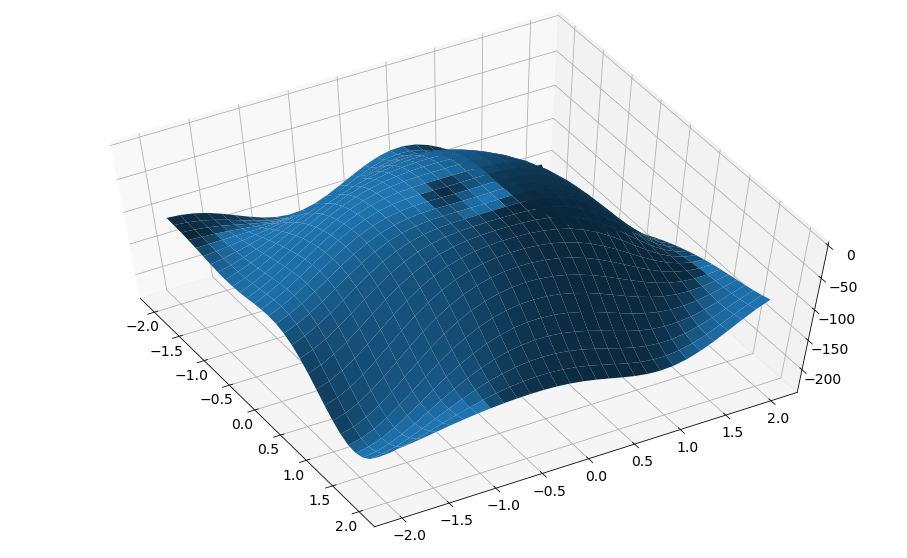

In [67]:
fig = plt.figure(figsize=(16, 10))
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=60, azim=-30)
ax.plot_surface(xx, yy, zz)

Notice that the learned barrier function is very smooth, but nevertheless has fairly aggressive derivatives -- its value decreases from 0 to -200 over a $\|x\|_\infty \leq 2$.  

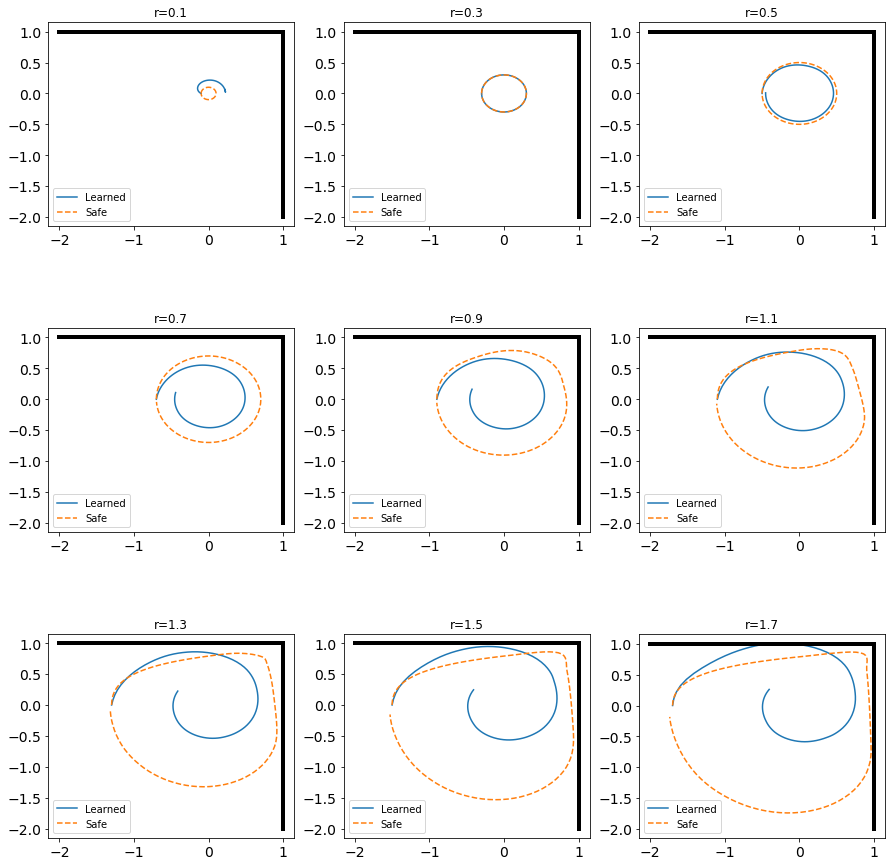

In [68]:
# first and last r_vals are outside of expert trajectories, so we expect learned controller to bias
# behavior away from nominal path.  r = 0.2 and r = 0.4 are on boundary, and so we expect near optimal
# behavior if we learned a faithful approximation
run_sims = True

if run_sims:
    r_vals = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7]

    fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(15,15))
    fig.subplots_adjust(hspace=0.5)

    for r, ax in zip(r_vals, axes.flatten()):
        learned_controller = make_safe_controller(r, 1, h_model, (params, bias_param, rf_weights))
        learned_closed_loop = lambda t, y: dynamics(y, learned_controller(y, t))
        safe_controller = make_safe_controller(r, 1, h, ())
        safe_closed_loop = lambda t, y: dynamics(y, safe_controller(y, t))
        x_start = np.array([-r, 0])
        t_end = 2 * np.pi
        t_eval = np.linspace(0, t_end, num=100)

        res_learned = scipy.integrate.solve_ivp(learned_closed_loop, (0, t_end), x_start, t_eval=t_eval)
        traj_learned = res_learned.y.T

        res_safe = scipy.integrate.solve_ivp(safe_closed_loop, (0, t_end), x_start, t_eval=t_eval)
        traj_safe = res_safe.y.T

        res_safe = scipy.integrate.solve_ivp(safe_closed_loop, (0, t_end), x_start, t_eval=t_eval)
        traj_safe = res_safe.y.T

        ax.plot(traj_learned[:, 0], traj_learned[:, 1])
        ax.plot(traj_safe[:, 0], traj_safe[:, 1], '--')
        ax.plot(np.linspace(-2, 1, num=20), np.ones((20,)), 'k', linewidth=4)
        ax.plot(np.array([1, 1]), np.array([-2, 1]), 'k', linewidth=4)
        ax.legend(['Learned', 'Safe'])
        ax.set(title='r={}'.format(r))

In [69]:
fig.savefig('traj.png') 

## Quick comments

Notice first that for $r=0.3$ we exactly reproduce the desired expert behavior, which is exactly what we would hope for.

Even more interestingly, notice that for radii that are smaller than the inner edge of expert trajectory torus (e.g., at $r=0.1$), and for radii that are (significantly) larger than the outer edge of the expert trajectory torus (e.g., at $r=0.5, 0.7, \dots$), we get the desired behavior that $\mathcal{C} = \{x \, | \, h(x) \geq 0 \}$ is asymptotically stable, even when the initial conditions are well beyond the certifiably valid set $\mathcal{D}\supset \mathcal{C}$.  What this suggests is that the Lipschitz smoothness properties that we impose on $h(x)$ and $dh/dx$ allow the derivative condition $\dot{h}(x_i,u_i) + \alpha(h(x_i)) \geq \gamma_{dyn}$ to genearlize to a non-trivial set that is even larger than the the union of epsilon-balls of the expert-trajectories defining $\mathcal{D}$ -- formally proving this is the subject of current work.

## Local Lipschitz Constant Calculations
In this section we verify that the slack conditions required for our theorems to hold are satisfied by the learned CBF.  We approximate the local Lipschitz constants by the norm of the gradient of the corresponding functions -- this approximation is reasonable due to the the scale of the epsilon values of .03333/2 and .03333.

In [70]:
# first, generate local lipschitz constant for q(x, u) for every point in (x_constraint, u_constraint)
x_q = np.vstack((x_constraint,x_filler))
u_q = np.vstack((u_constraint,u_filler))
xu_constraint_q_lipschitzs = vmap(lipschitz_constraint_q, in_axes=(0, 0, None, None, None))(x_q, u_q, params, bias_param, rf_weights)

In [71]:
# next, generate local slack in constraint hdot(x,u) - alpha(h(x)) - eps L_q(x) >= 0 (we want this to be positive)
derivative_slack = vmap(derivative_constraint_slack, in_axes=(0, 0, None, None, None, None))(x_q, u_q, params, bias_param, rf_weights,.03333/2)

In [72]:
# next, generate local lipschitz constant for h(x) for every point in x_constraint
x_constraint_h_lipschitzs = vmap(lipschitz_h, in_axes=(0, None, None, None))(x_constraint, params, bias_param, rf_weights)

In [73]:
# next, generate local lipschitz constants for h(x) for every point in unsafe_points
unsafe_points_h_lipschitzs = vmap(lipschitz_h, in_axes=(0, None, None, None))(unsafe_points, params, bias_param, rf_weights)
filler_points_h_lipschitzs = vmap(lipschitz_h, in_axes=(0, None, None, None))(x_filler, params, bias_param, rf_weights)

In [74]:
# fially, generate local slack in constraint h(x) + eps L(x_i) <= 0 for every point in unsafe_points (we want this to be negative)
unsafe_slack= vmap(unsafe_constraint_slack, in_axes=(0, None, None, None, None))(unsafe_points, params, bias_param, rf_weights,.03333)

In [75]:
unsafe_hvals= vmap(h_model, in_axes=(0, None, None, None))(unsafe_points, params, bias_param, rf_weights)
unsafe_lipgradhvals = vmap(lipschitz_grad_h, in_axes=(0, None, None, None))(unsafe_points, params, bias_param, rf_weights)

0.029332248


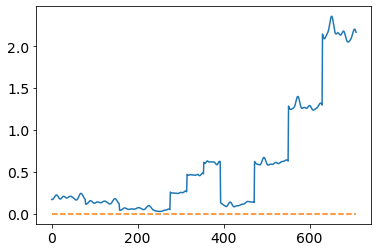

In [76]:
plt.plot(derivative_slack)
plt.plot(np.arange(len(derivative_slack)), np.zeros((len(derivative_slack),)), '--')
print(np.min(derivative_slack))

Here we are plotting $q(x_i,u_i) - L_q\epsilon$ for all $(x_i,u_i) \in X_{\mathrm{safe}}$, this should be positive

-0.011864308


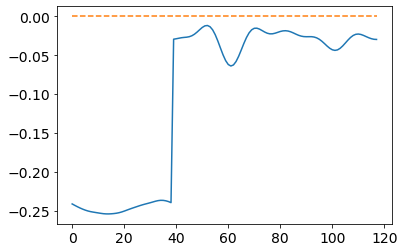

In [77]:
plt.plot(unsafe_slack)
plt.plot(np.arange(len(unsafe_slack)), np.zeros((len(unsafe_slack),)), '--')
print(np.max(unsafe_slack))

Here we are plotting $h(x_i) + L_h\bar{\epsilon}$ for all $x_i \in X_{\mathrm{unsafe}}$, this should be negative.

0.19922459


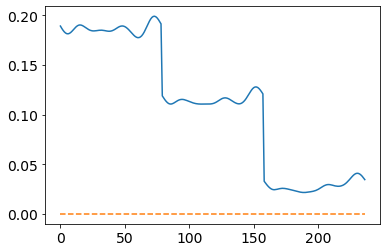

In [78]:
safe_slack = vmap(safe_constraint_slack, in_axes=(0, None, None, None, None))(x_constraint, params, bias_param, rf_weights,.03333)
plt.plot(safe_slack)
plt.plot(np.arange(len(safe_slack)), np.zeros((len(safe_slack),)), '--')
print(np.max(safe_slack))

Here we are plotting $h(x_i)-L_h\epsilon$ for all $x_i \in \bar{X}_{\mathrm{safe}}$, this should be positive.

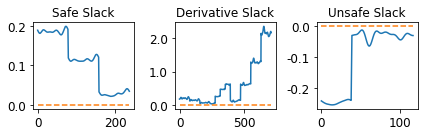

In [79]:
from matplotlib.ticker import FormatStrFormatter

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

plt.figure(figsize=(6, 2))

ax = plt.subplot(1, 3, 1)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_ticks([0.0, 0.1, 0.2])
plt.plot(safe_slack)
plt.plot(np.arange(len(safe_slack)), np.zeros((len(safe_slack),)), '--')
plt.title('Safe Slack', fontsize=12)

ax = plt.subplot(1, 3, 2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.plot(derivative_slack)
plt.plot(np.arange(len(derivative_slack)), np.zeros((len(derivative_slack),)), '--')
plt.title('Derivative Slack', fontsize=12)

ax = plt.subplot(1, 3, 3)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_ticks([-0.3, -0.2, -0.1, 0.0])
plt.plot(unsafe_slack)
plt.plot(np.arange(len(unsafe_slack)), np.zeros((len(unsafe_slack),)), '--')
plt.title('Unsafe Slack', fontsize=12)

plt.tight_layout()
plt.savefig('toy_2d_slacks.pdf', bbox_inches='tight')